In [12]:
import numpy as np
import matplotlib.pyplot as plt
from natsort import natsorted
import bead_utils as bu
import os, glob, re, importlib, numbers
import scipy.optimize as opt
import scipy.signal as sig
from matplotlib.backends.backend_pdf import PdfPages
import pickle

In [3]:
base_path = "/Volumes/DATA/"
sphere_data = []

calib_data = ["20231110/calibration"]
calib_noise_path = []

file_label= '20231110'
code_path = "/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis"
plots_dir = os.path.join(code_path, "plots", file_label)
if(not os.path.isdir(plots_dir)):
    os.makedirs(plots_dir)
data_dir = os.path.join(code_path, "data", file_label)
if(not os.path.isdir(data_dir)):
    os.makedirs(data_dir)


Now let's analyze whether there are any kicks correlated with the charge changes:

In [5]:
## create list of calibration files 
calib_file_dict = {}
coords_to_calib = ['x', 'y', 'z']

for curr_path in calib_data:

    for coord in coords_to_calib:
        fpath = os.path.join(base_path, curr_path, coord, "**MeV/*.h5")
        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file)

            if( coord in calib_file_dict.keys()):            
                if impulse_amp in calib_file_dict[coord].keys():
                    calib_file_dict[coord][impulse_amp].append(file)
                else:
                    calib_file_dict[coord][impulse_amp] = [file,] 
            else:
                calib_file_dict[coord] = {}
                calib_file_dict[coord][impulse_amp] = [file,]

noise_file_list = []
for curr_path in calib_noise_path:
    curr_file_list = natsorted(glob.glob(os.path.join(base_path, curr_path, "*.h5"), recursive=True))
    if(len(noise_file_list)>0):
        noise_file_list += curr_file_list
    else:
        noise_file_list = curr_file_list

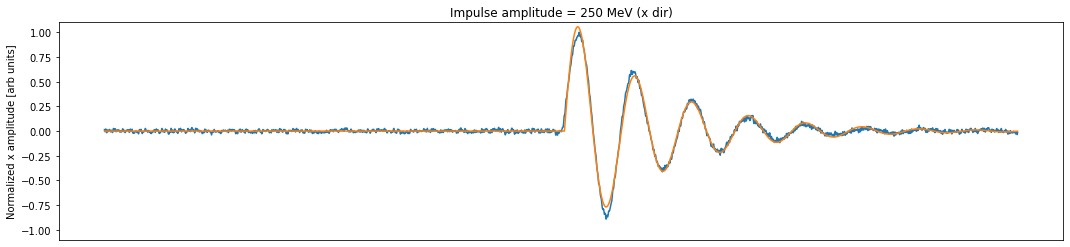

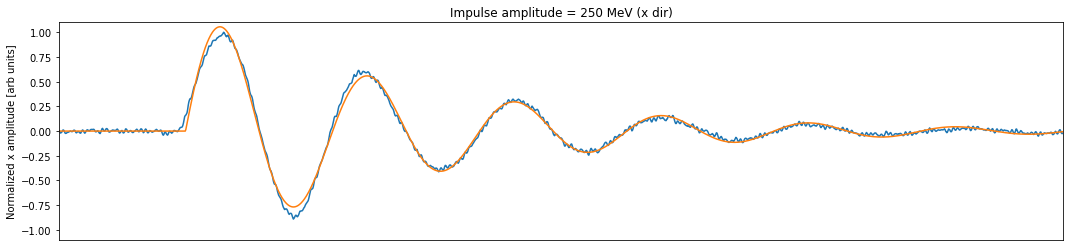

In [7]:
# calculate the pulse tempates by averaging all calibration files
importlib.reload(bu)
fit_pars_dict = {'x': [-1,2*np.pi*30,10,0.20],
                 'y': [-1,2*np.pi*70,10,0.20],
                 'z': [-1,2*np.pi*120,30,0.20]}
template_dict, template_dict_fit, fit_vals, norm_dict = bu.get_average_template_3D(calib_file_dict, make_plots=True,
                                                                        fit_pars=fit_pars_dict, drive_idx=10, coords_to_use=['x'])
plt.savefig(plots_dir+"/template_fits_%s.png"%file_label, dpi=300, bbox_inches="tight")

## plot with smaller x range
_, _, _, _ = bu.get_average_template_3D(calib_file_dict, make_plots=True, fit_pars=fit_pars_dict, 
                                     drive_idx=10, xrange=[0.18, 0.35], coords_to_use=['x'])
plt.savefig(plots_dir+"/template_fits_zoom_%s.png"%file_label, dpi=300, bbox_inches="tight")

In [9]:
template_fit_vals = fit_vals
coord_list = ['x']
print("Coord\tf_0 [Hz]\tgamma/(2pi) [Hz]")
for coord in coord_list:
    fp = fit_vals[coord][coord]
    print("%s\t%.1f\t\t%.1f"%(coord, fp[1]/(2*np.pi), fp[2]/(2*np.pi)))

Coord	f_0 [Hz]	gamma/(2pi) [Hz]
x	40.2		4.1


In [10]:
## using the above, we can calibrate into volts per meters
volts_per_meters = {}
MeV_to_kgms = 5.34e-22 ## 1 MeV in kg*m/s
msphere = 2.5e-14 ## 3 um sphere @ 1.8 g/cm^3 in kg
for coord in coord_list:
    fp = fit_vals[coord][coord]
    omega0, gam = fp[1], fp[2]
    omega1 = np.sqrt( omega0**2 - gam**2 )
    t = np.linspace(0, 10/(omega0/(2*np.pi)), 1000) ## 10 periods
    p0 = norm_dict[coord + "_amp"] * MeV_to_kgms
    volts_per_meters[coord] = norm_dict[coord]/(p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1))
    #print(volts_per_meters[coord])
    print("Max motion for 250 MeV [nm]: ", p0*np.max(np.exp(-gam*t)*np.sin(omega1*t))/(msphere*omega1)*1e9)

Max motion for 250 MeV [nm]:  18.207470787182462


In [11]:
def clean_axes(arr):
    plt.gca().set_xticks([0,1,2])
    plt.gca().set_yticks([0,1,2])
    plt.gca().set_xticklabels(['x', 'y', 'z'])
    plt.gca().set_yticklabels(['x', 'y', 'z'])
    plt.xlabel("Drive direction")
    plt.ylabel("Response direction")
    plt.colorbar(label="Normalized amplitude")

    for i in range(np.shape(arr)[0]):
        for j in range(np.shape(arr)[1]):
            if(arr[i,j]>0.9):
                plt.text(j,i,"%.1f"%arr[i,j],color='white',ha='center',va='center')
            else:
                plt.text(j,i,"%.1f"%arr[i,j],color='k',ha='center',va='center')
    

In [13]:
remake_files = False

if(remake_files):
    importlib.reload(bu)

    range_dict = {'x': [5,115], 'y': [5,200], 'z': [150, 400]}

    noise_dict_3D = bu.get_noise_template_3D(noise_file_list, fit_vals, range_dict, nfft=2**16)

    plt.savefig(plots_dir+"/noise_3D_%s.png"%file_label, dpi=300, bbox_inches="tight")

    ## save the noise templates
    with open(os.path.join(data_dir, "noise_dict_3D_%s.pkl"%file_label), 'wb') as f:
        pickle.dump(noise_dict_3D, f)

else:
    ## sub in old noise since we don't have it here
    file_label_old = "20231030"
    data_dir_old = os.path.join(code_path, "data", file_label_old)
    noise_dict_3D = pickle.load(open(os.path.join(data_dir_old, "noise_dict_3D_%s.pkl"%file_label_old), 'rb'))

In [16]:
importlib.reload(bu)
opt_filt_amps_1D = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
                   drive_idx=10, cal_fac=4.2e-8, make_plots=False, coord='x') 
#opt_filt_amps_1D_y = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
#                   drive_idx=10, cal_fac=1.5e-7, make_plots=False, coord='y') 
#opt_filt_amps_1D_z = bu.optimal_filt_1D(calib_file_dict, template_dict_fit, noise_dict_3D, time_offset=8, do_lp_filt=True,
#                        drive_idx=10, cal_fac=1.5e-7 * 200, make_plots=False, coord='z') 

/Users/dcmoore/Library/CloudStorage/GoogleDrive-david.c.moore@yale.edu/My Drive/yale/uspheres/decay_analysis/bead_utils.py:1355: RuntimeWarning: invalid value encountered in sqrt
  corr_data = np.sqrt(sp.filtfilt(b_lp, a_lp, corr_data**2))


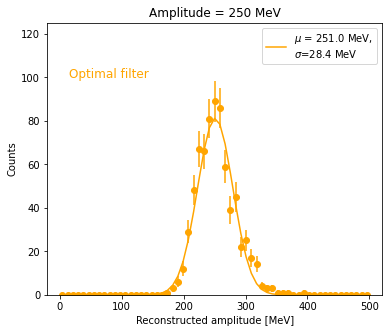

In [19]:
## compare various recon methods
amp_bins = np.arange(0,100,1.5)

def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

fit_vals = []

time_corr_amps = []
bandpass_amps = []
amp_dicts = [time_corr_amps, bandpass_amps, opt_filt_amps_1D]
amp_methods = ["Time correlation", "Simple bandpass", "Optimal filter", "Optimal filter (3D)"]
amp_cal_facs = [106.8, 6889, 1.057e-5, 1.057e-5] ## set by hand to match the calibration data  ##91.2, 
amp_colors = ['b', 'r', 'orange', 'g']

ymax = 125

plt.figure(figsize=(6,5))    
for i,filt_amps in enumerate(amp_dicts):
    if(i < 2): continue
    first_amp = True
    for j,amp in enumerate(filt_amps.keys()):
        if( not isinstance(amp, numbers.Number)): continue
        if(not first_amp): continue
        first_amp = False
        amp_bins = np.linspace(0,2*amp,60)
        ca = filt_amps[amp]*amp_cal_facs[i]
        gpts = (ca>0)
        amp_scale = amp/np.median(ca[gpts])
        hh,be = np.histogram(ca*amp_scale, bins=amp_bins)
        bc = be[:-1] + np.diff(be)/2

        ## gauss fit
        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, amp, 50])

        ## amplitude, mean, mean_err, sig, sig_err
        fit_vals.append([amp, gp[1], np.sqrt(gcov[1,1]), np.abs(gp[2]), np.sqrt(gcov[2,2]), i])

        #plt.subplot(3,3,j+1)
        plt.errorbar(bc, hh, yerr=np.sqrt(hh), fmt='o', color=amp_colors[i])
        plt.plot(bc, gauss_fun(bc, *gp), amp_colors[i], label="$\mu$ = %.1f MeV,\n$\sigma$=%.1f MeV"%(gp[1], gp[2]))
        plt.title("Amplitude = %d MeV"%amp)
        plt.ylabel("Counts")
        plt.xlabel("Reconstructed amplitude [MeV]")

        plt.text(15, ymax-(ymax/15)*(i+1), amp_methods[i], fontsize=12, color=amp_colors[i])

        #plt.suptitle(amp_methods[i])
        plt.legend()

    plt.ylim(0,ymax)
    plt.savefig(plots_dir+"/calib_reconstructed_amplitudes_%s.png"%file_label, dpi=300)

In [43]:
## assemble files for different freqs of drive
## create list of calibration files 
drive_file_dict = {}
coords_to_calib = [87, 111, 131, 141, 151, 161, 171]

drive_data = ["20231110/discharge_diff_freq"]

for curr_path in drive_data:

    for coord in coords_to_calib:
        fpath = os.path.join(base_path, curr_path, str(coord)+"Hz", "**mV/*.h5")
        curr_file_list = natsorted(glob.glob(fpath, recursive=True))

        for file in curr_file_list:
            impulse_amp = bu.parse_impulse_amplitude(file, "mV")
            if( coord in drive_file_dict.keys()):            
                if impulse_amp in drive_file_dict[coord].keys():
                    drive_file_dict[coord][impulse_amp].append(file)
                else:
                    drive_file_dict[coord][impulse_amp] = [file,] 
            else:
                drive_file_dict[coord] = {}
                drive_file_dict[coord][impulse_amp] = [file,]

In [97]:
importlib.reload(bu)

amp_dict = {}

num_pts_per_charge_recon = 2**13 ## points to use in each fft segment for charge reconstruction

for freq in drive_file_dict.keys():

    amp_dict[freq] = {}

    for amp in drive_file_dict[freq].keys():

        corr_vec = []

        flist = drive_file_dict[freq][amp]

        print("Working on %d Hz, %d mV"%(freq, amp))

        for i, f in enumerate(flist):

            cdat, attr, fhandle = bu.get_data(f)

            curr_corr_vec = bu.signed_correlation_with_drive(cdat, attr, nperseg=num_pts_per_charge_recon, drive_idx=10)
            if(i == 0):
                corr_vec = 1.0*curr_corr_vec
            else:
                corr_vec = np.vstack((corr_vec, curr_corr_vec))

        amp_dict[freq][amp] = corr_vec



Working on 87 Hz, 200 mV
0.03465585940506438
Working on 111 Hz, 200 mV
0.03464663602574583
Working on 131 Hz, 200 mV
0.034658926201691434
Working on 131 Hz, 250 mV
0.04332369603696074
Working on 131 Hz, 300 mV
0.05201397469820597
Working on 141 Hz, 200 mV
0.03463577326064584
Working on 141 Hz, 300 mV
0.05199352154116454
Working on 141 Hz, 400 mV
0.06918032666552543
Working on 151 Hz, 150 mV
0.025988267222627252
Working on 151 Hz, 200 mV
0.034639398478674
Working on 151 Hz, 300 mV
0.051994007683610864
Working on 151 Hz, 400 mV
0.06917860002668416
Working on 161 Hz, 200 mV
0.03463530023920601
Working on 161 Hz, 250 mV
0.04330246189057586
Working on 161 Hz, 300 mV
0.05198955617756506
Working on 171 Hz, 200 mV
0.03466081890545569
Working on 171 Hz, 300 mV
0.05201176659876018
Working on 171 Hz, 400 mV
0.069204480771246
Working on 171 Hz, 500 mV
0.0863259421098875
Working on 171 Hz, 600 mV
0.10347039947196154


In [ ]:
def gauss_fun(x,A,mu,sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

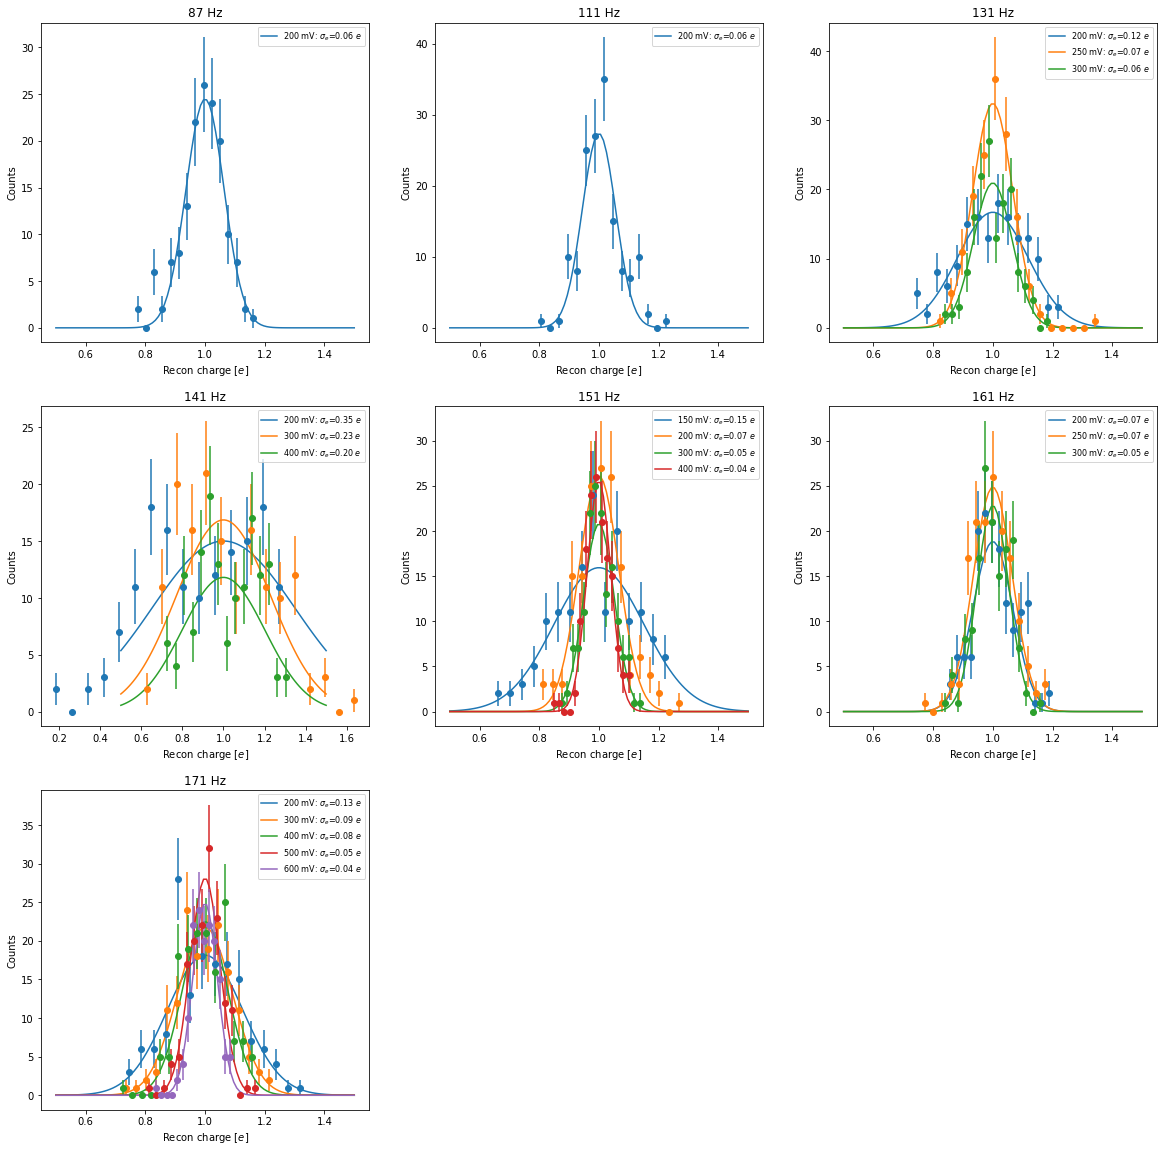

In [105]:
plt.figure(figsize=(20,20))

col_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

res_list = []
for jf, freq in enumerate(amp_dict.keys()):
    plt.subplot(3, 3, jf+1)
    for ja, amp in enumerate(amp_dict[freq].keys()):

        cd = amp_dict[freq][amp][:,2]
        hh, be = np.histogram(cd, bins=15)
        bc = be[:-1] + np.diff(be)/2

        err = np.sqrt(hh)
        err[err==0] = 1
        gp, gcov = opt.curve_fit(gauss_fun, bc, hh, sigma=err, p0=[1, np.median(cd), np.std(cd)])

        bc2 = bc/gp[1]

        res_list.append([freq, amp, gp[2]/gp[1], np.sqrt(gcov[2,2])/gp[1]])

        plt.errorbar(bc2, hh, yerr=np.sqrt(hh), fmt='o', color=col_list[ja])
        xx = np.linspace(0.5,1.5,100)
        plt.plot(xx, gauss_fun(xx*gp[1], *gp), color=col_list[ja], label="%d mV: $\sigma_e$=%.2f $e$"%(amp, gp[2]/gp[1]))
        plt.xlabel("Recon charge [$e$]")
        plt.ylabel("Counts")
        plt.legend(fontsize=8)
    
    plt.title("%d Hz"%freq)

plt.savefig(plots_dir+"/charge_recon_sig_%s.png"%file_label, dpi=300, bbox_inches="tight")


In [ ]:
res_list = np.array(res_list)

freq_list = np.unique(res_list[:,0])

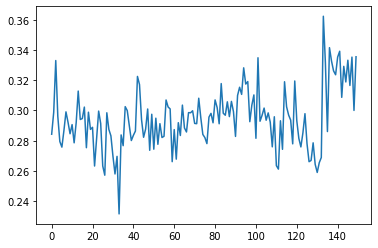

In [78]:
cal_fac = 0.072 * np.median(corr_vec[:,3])/170.5 ## scaling to nominal previous calibration factor
plt.plot(amp_dict[111][200][:,2]/cal_fac)